In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import kneighbors_graph, radius_neighbors_graph
from sklearn.metrics import pairwise_distances as all_dist
import networkx as nx

In [0]:
def GeoDist(data, method='K', param=4):
    n = data.shape[0]
    if method == 'K':
        edges = kneighbors_graph(data, param, mode='distance').toarray()
    elif method == 'e':
        edges = radius_neighbors_graph(data, param, mode='distance').toarray()
    edges[edges==0] = np.inf
    np.fill_diagonal(edges,0)
    G = nx.Graph()
    for i in range(n):
        for j in range(i+1, n):
            G.add_edge(i,j,weight=edges[i,j])
    return nx.algorithms.shortest_paths.dense.floyd_warshall_numpy(G)  

triu = np.triu_indices

In [0]:
class GeoNLM:
    def __init__(self, p, alfa, method='K', param=15):
        self.p = p # Nova dimensão
        self.alfa = alfa # Taxa de aprendizagem, entre 0.3 e 0.4
        self.method = method
        self.param = param

    def transform(self, data):
        pca = PCA(n_components = self.p)
        return pca.fit_transform(data)

    def stress(self, dist_y, data_x):
        c = self.c
        n = dist_y.shape[0]
        dy = dist_y[self.triu]
        dist_x = all_dist(data_x)[self.triu]
        dx = dist_x.reshape((1,-1))
        sub = np.ravel(dy-dx)
        soma_m = sub**2 /dy
        soma = np.sum(soma_m)
        return soma/c

    def derivate_1(self, i, dist_y, data_x, dist_x):
        c = self.c
        n = dist_y.shape[0]
        dx = (np.delete(dist_x[i,:],i)).reshape((1,-1))
        dy = np.delete(dist_y[i,:],i)
        dy = dy.reshape((1,-1))
        soma = np.dot( (dy - dx)/np.multiply(dx,dy) , np.delete(data_x[i,:] - data_x, i, 0) )
        return -2*soma/c

    def derivate_2(self, i, dist_y, data_x, dist_x):
        c = self.c
        n = dist_y.shape[0]
        dx = np.ravel(np.delete(dist_x[i,:],i))
        dy = np.ravel(np.delete(dist_y[i,:],i))
        soma = np.zeros(data_x.shape[1])
        for j in range(soma.size):
            soma[j] = np.sum( (dy - dx)/(dx*dy) - np.delete(data_x[i,j] - data_x[:,j], i, 0)**2 /dx**3 )
        return np.abs((-2)*soma/c)

    def run(self, data_y, i_max = 10, show=False):
        stress = np.zeros(i_max) 
        n = data_y.shape[0]
        data_x = self.transform(data_y)
        dist_y = GeoDist(data_y, self.method, self.param)
        self.triu = triu(dist_y.shape[0],1)
        self.c = np.sum(dist_y[self.triu])
        score = np.zeros(i_max)
        for repeat in range(i_max):
            score[repeat] = self.stress(dist_y, data_x)
            dist_x = all_dist(data_x)
            delta_x = np.zeros(data_x.shape)
            for i in range(data_y.shape[0]):  
                delta_x[i,:] = self.derivate_1(i,dist_y, data_x, dist_x)/self.derivate_2(i, dist_y, data_x, dist_x)
            data_x -= self.alfa*delta_x
        print(score[-1])
        if show:
            plt.plot(np.arange(i_max), score)
            plt.show()
        return data_x

179.68686608841475


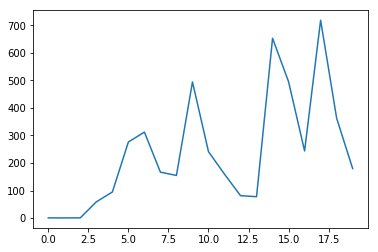

368.0175189971924


In [0]:
x = np.random.random((3000,64))
import time
s1 = time.time()
g = GeoNLM(8, 0.3, param=40)
a = g.run(x, i_max=20, show=True)
print(time.time()-s1)